Визуализировать KL-дивергенцию (в трех вариантах, KL(p1,p2), KL(p2,p1) и 0.5 KL(p1,p2) + 0.5 KL(p2,p1)) между истинным распределением выборки и распределением генератора GAN зависимости от количества итераций оптимизации. Выборка: синтетическая. Модель GAN: максимально простая для сгенерированной выборки.

Я взял 2х слойный перцептор в качестве генератора, а в качетсве истинного распределения $\mathcal{N}(0, 1/10)$.

In [ ]:
from typing import Optional
import math
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy import stats

In [ ]:
dist = MultivariateNormal(torch.ones(2), torch.eye(2)/10)

Будем преобразовывать U[0, 1] в нормальное $\mathcal{N}(0, 1/10)$. Для подсчета дивергенции Кульбака-Лейблера.:

In [ ]:
def get_KL(vals, dist, reverse=False):
    kernel = stats.gaussian_kde(vals.numpy().T)
    min_x, min_y = vals.numpy().min(0)
    max_x, max_y = vals.numpy().max(0)
    points = np.random.rand(vals.size(0), 2) * [max_x - min_x, max_y - min_y] + [min_x, min_y]
    
    a = kernel(points.T)
    b_log = dist.log_prob(vals)
    b = b_log.exp().numpy()
    if reverse:
        return np.sum(b * (b_log.numpy() - np.log(a))) / ( (max_y - min_y) * (max_x - min_x) )
    else:
        return np.sum(a * (np.log(a) - b_log.numpy())) / ( (max_y - min_y) * (max_x - min_x) )

Так как мы не умеем считать дивергенцию KL между известным распределением и семплами из второго. Поэтому я строю эмпирическое распределение по нашим данным и сглаживаю его пользуясь функций `gaussian_kde`. После того, как получил апроксимацию распределения, я считаю интеграл как сумму по набору точек. Так как в подсчете идет работа с очень маленьими значениями и нет возможности сделать бесконечно большой набор семплов, то получается так, что значение логарифма получается часто некорректным. Особенно это заметно при подсчете обратной дивергенции.

Пробовал различные методы, например, считал гистограмму, строил реальное эмпирическое распределение и т.д. Никакие методы хорошо не работали.

In [ ]:
v = dist.sample((1000,))
for i in range(10):
    print(get_KL(v + i, dist, False))

-5.099554539044582
612.2805054396989
2532.195089422739
5929.037227035028
9838.653559921391
15346.944632062266
23367.841250397745
30735.3358281147
41399.26441620192
54945.83561642193


In [ ]:
for i in range(10):
    print(get_KL(v + i, dist, True))

628.7811461512979
0.9992281073321333
-9.39131891522962e-07
-2.5255365135863263e-21
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
class Generator(nn.Module):
    def __init__(self, in_size, out_size, hidden_size):
        super(Generator, self).__init__()
        self.net = nn.Sequential(nn.Linear(in_size, hidden_size),
                                #  nn.BatchNorm1d(hidden_size),
                                 nn.Sigmoid(),
                                 nn.Linear(hidden_size, out_size),
                                 nn.Tanh())
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, in_size, hidden_size):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(nn.Linear(in_size, hidden_size),
                                 nn.BatchNorm1d(hidden_size),
                                 nn.Sigmoid(),
                                 nn.Linear(hidden_size, 1),
                                 nn.Sigmoid())

    def forward(self, x):
        return self.net(x)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def train_epoch(netG, netD, optimizerG, optimizerD, criterion, dist, b_size = 10, wgan=False):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) # for GAN
    ###########################
    optimizerD.zero_grad()
    # Format batch
    real_cpu = dist.sample((b_size,)).cuda()
    label_real = torch.full((b_size,), real_label, dtype=torch.float, device='cuda')
    label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device='cuda')
    # Forward pass real batch through D
    output_real = netD(real_cpu).view(-1)
    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, 2, device='cuda')
    # Generate fake image batch with G
    fake = netG(noise)
    # Classify all fake batch with D
    output_fake = netD(fake.detach()).view(-1)

    if wgan:
        # Adversarial loss
        errD = -torch.mean(output_real) + torch.mean(output_fake)
    else:
        # Calculate loss on all-real batch
        errD_real = criterion(output_real, label_real)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output_fake, label_fake)
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD.backward()
    # Update D
    optimizerD.step()
    
    if wgan:    
        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)

    D_G_z1 = output_fake.mean().item()
    D_x = output_real.mean().item()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    optimizerG.zero_grad()
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    if wgan:
        errG = -torch.mean(output)
    else:
        errG = criterion(output, label_fake)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    return errG, errD, D_x, D_G_z1, D_G_z2

In [ ]:
# Create the generator
netG = Generator(2, 2, 5).cuda()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(2, 2).cuda()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=2, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = dist.sample((10000,)).cuda()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

clip_value = 0.01

lr = 0.001
beta1 = 0.5
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr/10)

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
res_KL = []
iters = 0
num_epochs = 100000

print("Starting Training Loop...")
for epoch in range(num_epochs):

    errG, errD, D_x, D_G_z1, D_G_z2 = train_epoch(netG, netD, optimizerG, optimizerD, criterion, dist, b_size = 1000, wgan=False)
    # Output training stats
    if (epoch % (num_epochs//10) == 0) :
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (epoch % (num_epochs//100) == 0) :
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            res_KL.append(get_KL(fake, dist, False))
        img_list.append(fake)

Starting Training Loop...
[0/100000]	Loss_D: 1.4543	Loss_G: 0.4657	D(x): 0.3718	D(G(z)): 0.3718 / 0.3723
[10000/100000]	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[20000/100000]	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[30000/100000]	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[40000/100000]	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[50000/100000]	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[60000/100000]	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[70000/100000]	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[80000/100000]	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000
[90000/100000]	Loss_D: 1.3863	Loss_G: 0.6931	D(x): 0.5000	D(G(z)): 0.5000 / 0.5000


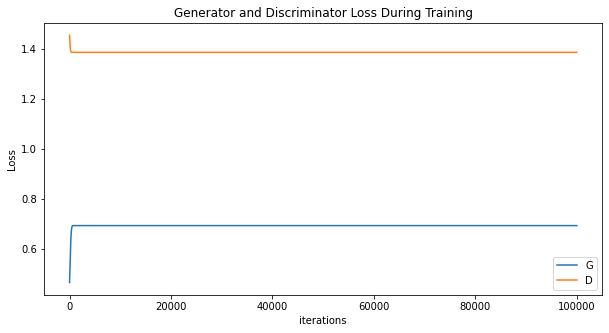

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

В начале обучения я зафиксировал случайный шум, будем с ним далее работать. Преобразуем этот шум с помощью генератора и нарисуем итоговое распределение. Скорее всего (как у меня почти все время получалось) получится колапс моды. Это известная проблема для обычного GAN-a. Я также попробовал обучить WGAN.

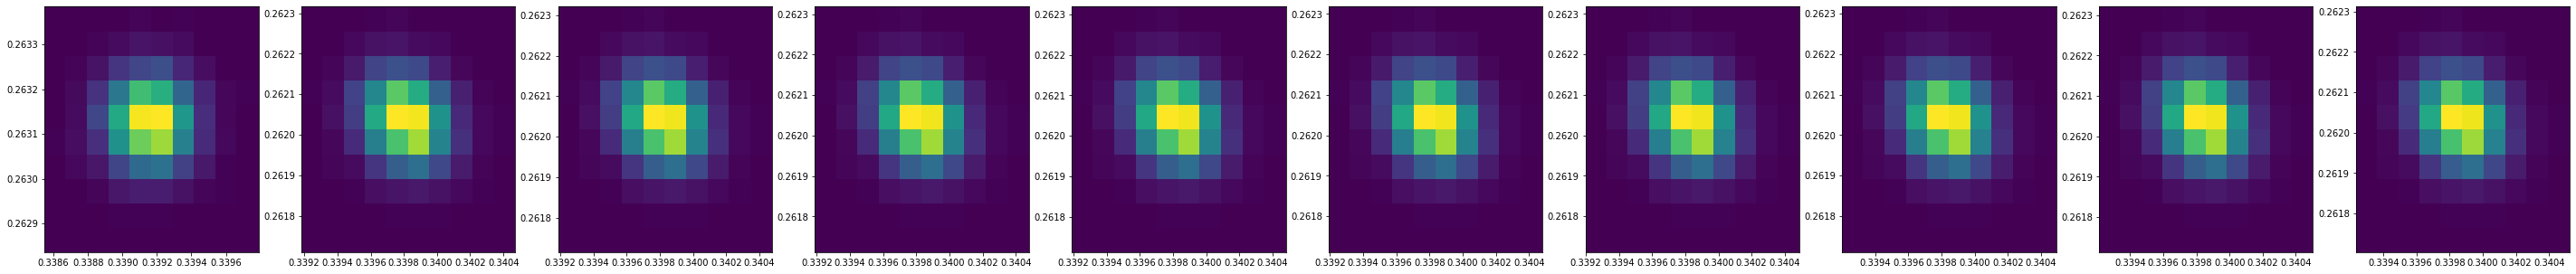

In [ ]:
N_IMGS = 10
step = len(img_list) // (N_IMGS - 1)
fig, axs = plt.subplots(1, N_IMGS, figsize=(5 * N_IMGS, 5))
for i in range(N_IMGS):
    axs[i].hist2d(img_list[i * step].numpy()[:, 0], img_list[i * step].numpy()[:, 1])
plt.show()

Так как случается колапс моды, то получается, что дивергенция Кульбака-Лейблера уходит в бесконечность.

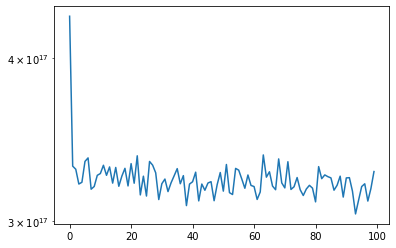

In [ ]:
plt.plot(res_KL)
plt.yscale('log')

In [144]:
# Create the generator
netG = Generator(2, 2, 5).cuda()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(2, 2).cuda()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=2, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [145]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = dist.sample((10000,)).cuda()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

clip_value = 0.1

lr = 0.1
beta1 = 0.5
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr/5)

In [146]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
res_KL = []
iters = 0
num_epochs = 100000

print("Starting Training Loop...")
for epoch in range(num_epochs):

    errG, errD, D_x, D_G_z1, D_G_z2 = train_epoch(netG, netD, optimizerG, optimizerD, criterion, dist, b_size = 100, wgan=True)
    # Output training stats
    if (epoch % (num_epochs//10) == 0) :
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (epoch % (num_epochs//100) == 0) :
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            res_KL.append(get_KL(fake, dist, False))
        img_list.append(fake)

Starting Training Loop...
[0/100000]	Loss_D: 0.0000	Loss_G: -0.4970	D(x): 0.4382	D(G(z)): 0.4382 / 0.4970


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


[10000/100000]	Loss_D: -0.0000	Loss_G: -0.5511	D(x): 0.5511	D(G(z)): 0.5511 / 0.5511
[20000/100000]	Loss_D: -0.0000	Loss_G: -0.5511	D(x): 0.5511	D(G(z)): 0.5511 / 0.5511
[30000/100000]	Loss_D: -0.0000	Loss_G: -0.5507	D(x): 0.5507	D(G(z)): 0.5507 / 0.5507
[40000/100000]	Loss_D: -0.0000	Loss_G: -0.5510	D(x): 0.5511	D(G(z)): 0.5511 / 0.5510
[50000/100000]	Loss_D: -0.0000	Loss_G: -0.5509	D(x): 0.5510	D(G(z)): 0.5510 / 0.5509


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
N_IMGS = 10
step = len(img_list) // (N_IMGS - 1)
fig, axs = plt.subplots(1, N_IMGS, figsize=(5 * N_IMGS, 5))
for i in range(N_IMGS):
    axs[i].hist2d(img_list[i * step].numpy()[:, 0], img_list[i * step].numpy()[:, 1])
plt.show()

In [ ]:
plt.plot(res_KL)
plt.yscale('log')